# Reverberation

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['axes.grid'] = True
np.random.seed(42)

db_to_mag = lambda x: 10 ** (x / 20)
mag_to_db = lambda x: 20 * np.log10(x)

## Generate a synthetic room impulse response (RIR)

In [85]:
# Generate time axis (in milliseconds)
time_array = np.linspace(0, 400, 250)

# Exponential decay with noise
rir = np.exp(-0.01 * time_array) * (1 + 0.1 * np.random.randn(len(time_array)))
rir = np.clip(rir, 0, None)  # Ensure no negative values
rir /= np.max(np.abs(rir))  # Normalize to 1

In [86]:
# Define colormap and colors
cmap = plt.get_cmap("RdYlBu") 
colors = [cmap(0.1), cmap(0.4), cmap(0.8), cmap(1.0)]  # Select spaced points along the colormap

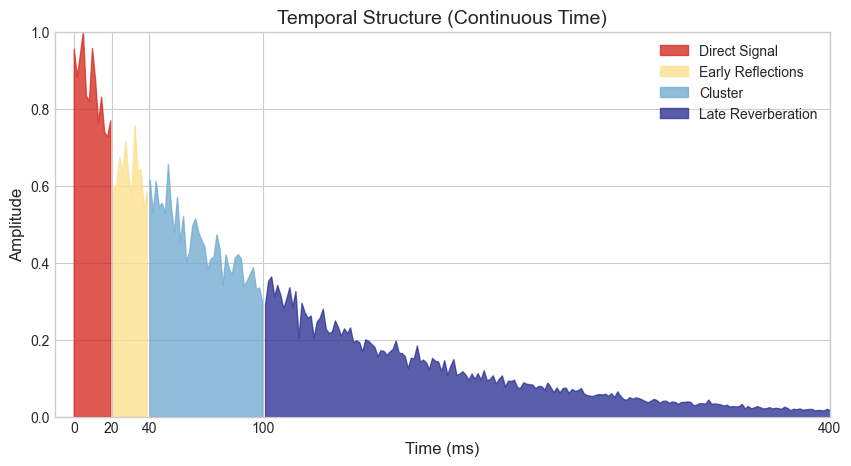

In [87]:
# Define exact transition points in milliseconds
direct_end = 20
early_reflections_end = 40
cluster_end = 100
late_reverb_start = 100

# Define regions for coloring
direct_region = (time_array <= direct_end)
early_reflections_region = (time_array > direct_end) & (time_array <= early_reflections_end)
cluster_region = (time_array > early_reflections_end) & (time_array <= cluster_end)
late_reverb_region = (time_array > late_reverb_start)


# Plotting the waveform
plt.figure(figsize=(10, 5))

# Fill regions with distinct colors
plt.fill_between(
    time_array, rir, where=direct_region, 
    color=colors[0], alpha=0.8, label="Direct Signal"
)
plt.fill_between(
    time_array, rir, where=early_reflections_region, 
    color=colors[1], alpha=0.8, label="Early Reflections"
)
plt.fill_between(
    time_array, rir, where=cluster_region, 
    color=colors[2], alpha=0.8, label="Cluster"
)
plt.fill_between(
    time_array, rir, where=late_reverb_region, 
    color=colors[3], alpha=0.8, label="Late Reverberation"
)

# General plot settings
plt.ylim(0, 1)
plt.xlim(-10, 400)
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Amplitude", fontsize=12)
plt.xticks([0, 20, 40, 100, 400])
plt.title("Temporal Structure (Continuous Time)", fontsize=14)
plt.legend()
# plt.grid(alpha=0.3)
plt.show()

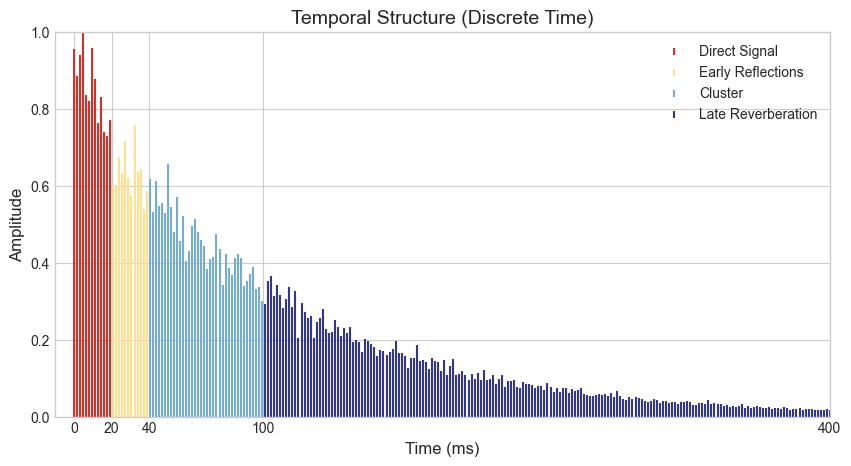

In [88]:
# Define exact transition points in milliseconds
direct_end = 20
early_reflections_end = 40
cluster_end = 100
late_reverb_start = 100

# Define regions for coloring
direct_region = (time_array <= direct_end)
early_reflections_region = (time_array > direct_end) & (time_array <= early_reflections_end)
cluster_region = (time_array > early_reflections_end) & (time_array <= cluster_end)
late_reverb_region = (time_array > late_reverb_start)

# Plotting the discrete version
plt.figure(figsize=(10, 5))

# Direct signal
plt.stem(
    time_array[direct_region],
    rir[direct_region],
    linefmt=colors[0],
    markerfmt="",
    basefmt=" ",
    label="Direct Signal",
).markerline.set_markersize(4)

# Early reflections
plt.stem(
    time_array[early_reflections_region],
    rir[early_reflections_region],
    linefmt=colors[1],
    markerfmt="",
    basefmt=" ",
    label="Early Reflections",
).markerline.set_markersize(4)

# Cluster
plt.stem(
    time_array[cluster_region],
    rir[cluster_region],
    linefmt=colors[2],
    markerfmt="",
    basefmt=" ",
    label="Cluster",
).markerline.set_markersize(4)

# Late reverberation
plt.stem(
    time_array[late_reverb_region],
    rir[late_reverb_region],
    linefmt=colors[3],
    markerfmt="",
    basefmt=" ",
    label="Late Reverberation",
).markerline.set_markersize(4)

# General plot settings
plt.ylim(0, 1.)
plt.xlim(-10, 400)
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Amplitude", fontsize=12)
plt.xticks([0, 20, 40, 100, 400])
plt.title("Temporal Structure (Discrete Time)", fontsize=14)
plt.legend()
# plt.grid(alpha=0.3)
plt.show()


## Plot the Waterfall plot of the RIR

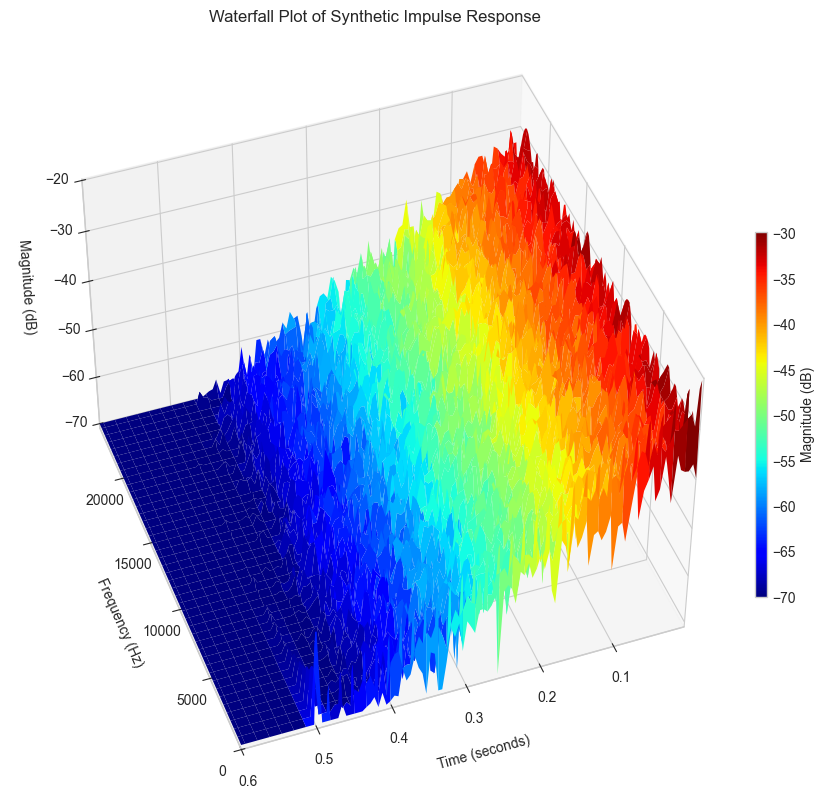

In [89]:
def generate_spectrogram(waveform, sample_rate, magnitude_range=(-70, 0)):
    # Compute the spectrogram
    frequencies, times, Sxx = signal.spectrogram(
        waveform, 
        fs=sample_rate, 
        window='blackmanharris',
        nperseg=256,  # Adjusted for better frequency resolution
        noverlap=128,  # Adjusted for overlap
        scaling='spectrum', 
        mode='magnitude'
    )
    
    # Convert magnitude to dB
    Sxx_dB = 10 * np.log10(Sxx + 1e-10)
    
    # Apply magnitude range limits
    min_db, max_db = magnitude_range
    Sxx_dB = np.clip(Sxx_dB, min_db, max_db)
    
    return frequencies, times, Sxx_dB

def plot_waterfall(waveform, title, sample_rate, stride=1, time_range=None, magnitude_range=(-70, 0)):
    frequencies, times, Sxx = generate_spectrogram(waveform, sample_rate, magnitude_range)

    # Apply the specified time range if provided
    if time_range is not None:
        start_time, end_time = time_range
        if end_time > times[-1]:  # Extend waveform if time range exceeds signal duration
            padding_length = int((end_time - times[-1]) * sample_rate)
            waveform = np.concatenate((waveform, np.zeros(padding_length)))
            frequencies, times, Sxx = generate_spectrogram(waveform, sample_rate, magnitude_range)
        time_mask = (times >= start_time) & (times <= end_time)
        times = times[time_mask]  # Filter times
        Sxx = Sxx[:, time_mask]  # Filter corresponding spectrogram values

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create the meshgrid for the waterfall plot
    X, Y = np.meshgrid(times[::stride], frequencies)  # Flip X and Y to match time-frequency order
    Z = Sxx[:, ::stride]  # Corresponding slice for Z

    # Plot the surface
    surf = ax.plot_surface(X, Y, Z, 
                           cmap='jet',
                           edgecolor='none', 
                           alpha=1.0)

    # Add a color bar
    cbar = fig.colorbar(surf, ax=ax, pad=0.01, aspect=30, shrink=0.5)
    cbar.set_label('Magnitude (dB)')

    # Set axis labels and title
    ax.set_xlabel('Time (seconds)', labelpad=10)
    ax.set_ylabel('Frequency (Hz)', labelpad=10)
    ax.set_zlabel('Magnitude (dB)', labelpad=10)
    ax.set_title(title, pad=20)

    # Flip the y-axis (frequency) if needed to show low-to-high
    ax.set_ylim([frequencies[0], frequencies[-1]])
    ax.set_xlim([times[-1], times[0]])

    # Adjust the view angle for better visualization
    ax.view_init(elev=45, azim=-110)

    plt.tight_layout()
    plt.show()

# Generate a synthetic impulse response
time_array = np.linspace(0, 1, 48000)  # 1-second signal at 48 kHz

# Create a decaying exponential for the first half
rir = np.zeros_like(time_array)  # Initialize the full signal with silence
half_length = len(time_array) // 2
rir[:half_length] = np.exp(-20 * time_array[:half_length]) * (1 + 0.01 * np.random.randn(half_length))  # Fill only half

# Optional: Normalize to ensure proper scaling
rir /= np.max(np.abs(rir))

# Use the extended signal for visualization
title = 'Waterfall Plot of Synthetic Impulse Response'

# Specify a custom time range in seconds and magnitude range
time_range = (0., 0.6)  # Visualize from 0.5 to 1.5 seconds (beyond the signal duration)
magnitude_range = (-70, 0)  # Limit magnitude to the range [-70, 0] dB
plot_waterfall(rir, title, 48000, stride=2, time_range=time_range, magnitude_range=magnitude_range)


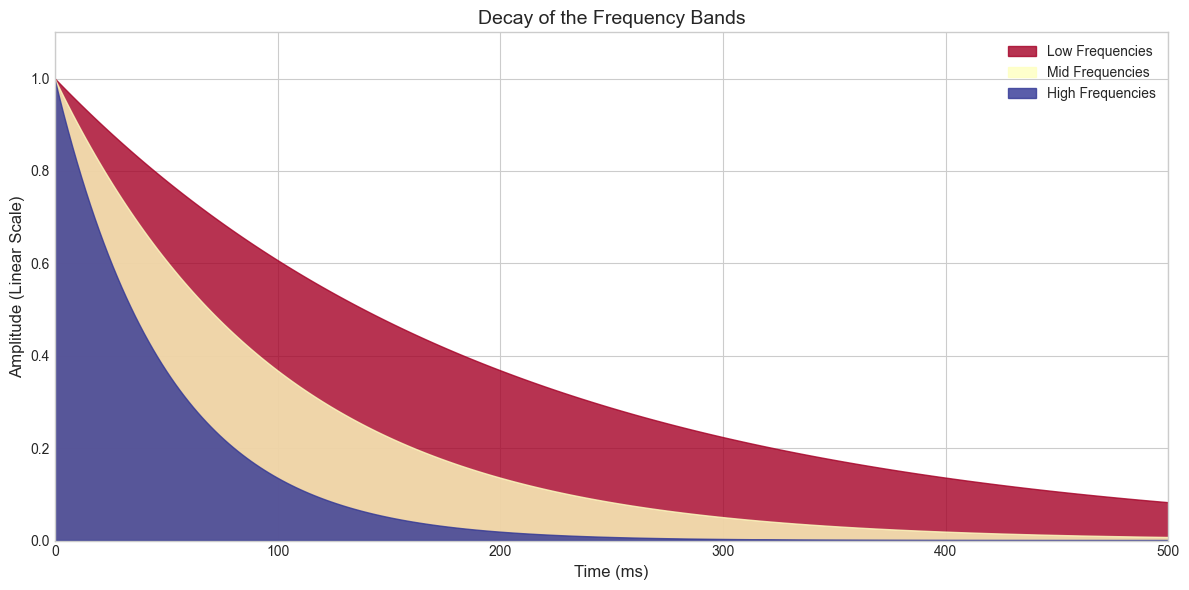

In [91]:
# Define colormap and colors
cmap = plt.get_cmap("RdYlBu") 
num_colors = 3

# select points in the colormap and add them to a list
points_colors = np.linspace(0, 1, num_colors)
colors = [cmap(point) for point in points_colors]

# Parameters
RT_0 = 500  # Reverberation Time (ms)
time = np.linspace(0, (2 * RT_0), RT_0) # Time vector (ms)

# Crossover frequencies
freq_low = 250  # Low frequency (Hz)
freq_hi = 6000  # High frequency (Hz)

room_size = 2000  # Room size in cubic meters

# Relative decay for low, mid, and high frequencies
rt_low = 0.4
rt_mid = 0.2
rt_hi = 0.1 

# # Gains in dBFS
direct_gain = db_to_mag(0.0)
early_gain = db_to_mag(-8.5)
late_gain = db_to_mag(0.0)

# Calculate decay functions ensuring they reach 0 at the end of RT_0
low_decay = np.exp(-time / (RT_0 * rt_low))
mid_decay = np.exp(-time / (RT_0 * rt_mid))
hi_decay = np.exp(-time / (RT_0 * rt_hi))

# Plot
plt.figure(figsize=(12, 6))

plt.fill_between(time, low_decay, color=colors[0], alpha=0.8, label="Low Frequencies")
plt.fill_between(time, mid_decay, color=colors[1], alpha=0.8, label="Mid Frequencies")
plt.fill_between(time, hi_decay, color=colors[2], alpha=0.8, label="High Frequencies")

# Plot settings
plt.title("Decay of the Frequency Bands", fontsize=14)
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Amplitude (Linear Scale)", fontsize=12)
plt.xlim(0, RT_0)
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.show()